In [1]:
!nvidia-smi

Wed Aug 16 05:52:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torch_geometric
!pip install rdkit

In [3]:
import torch
import torch_geometric
import rdkit
from torch_geometric.datasets import MoleculeNet
from torchsummary import summary

In [4]:
data= MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [5]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


In [6]:
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [7]:
data[1]["smiles"]

'Cc1occc1C(=O)Nc2ccccc2'

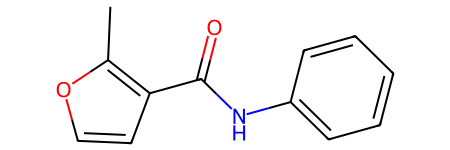

In [8]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule=Chem.MolFromSmiles(data[1]["smiles"])
molecule

In [9]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,TopKPooling,global_mean_pool
from torch_geometric.nn import global_mean_pool as gap,global_max_pool as gmp

In [10]:
embedding_size = 128

In [16]:
class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # GCN layers
    self.initial_conv= GCNConv(data.num_features,embedding_size)
    self.conv1= GCNConv(embedding_size,embedding_size)
    self.conv2= GCNConv(embedding_size,embedding_size)
    self.conv3= GCNConv(embedding_size,embedding_size)

    #Output
    self.out= Linear(embedding_size*2,1)

  def forward(self,x,edge_index,batch_index):
    # First Conv
    hidden = self.initial_conv(x,edge_index)
    hidden = F.tanh(hidden)
    # Other Conv Layer
    hidden = self.conv1(hidden,edge_index)
    hidden = F.tanh(hidden)
    hidden = self.conv2(hidden,edge_index)
    hidden = F.tanh(hidden)
    hidden = self.conv2(hidden,edge_index)
    hidden = F.tanh(hidden)

    hidden = torch.cat([gmp(hidden,batch_index),
                        gap(hidden,batch_index)],dim=1)
    out = self.out(hidden)
    return out,hidden

In [17]:
model = GCN()
print(model)

GCN(
  (initial_conv): GCNConv(9, 128)
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (out): Linear(in_features=256, out_features=1, bias=True)
)


In [18]:
from torch_geometric.data import DataLoader
loss_fn= torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.005)

device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
model=model.to(device)
data_size=len(data)
batch_size=64
train_dl = DataLoader(data[:int(data_size * 0.8)],
                      batch_size=batch_size,shuffle=True)
test_dl = DataLoader(data[int(data_size * 0.8):],
                      batch_size=batch_size,shuffle=True)

In [19]:
train_dl

In [20]:
def train(data):
  for batch in train_dl:
    batch.to(device)
    optimizer.zero_grad()
    pred,embedding =  model(batch.x.float(),batch.edge_index,batch.batch)
    loss=loss_fn(pred,batch.y)
    loss.backward()
    optimizer.step()
  return loss, embedding

print("Starting trainig...")
losses=[]

for epoch in range(2000):
  loss,h = train(data)
  losses.append(loss)
  if(epoch % 100 == 0):
    print(f'Epoch {epoch} | Train Loss {loss}')

Starting trainig...
Epoch 0 | Train Loss 2.5554285049438477
Epoch 100 | Train Loss 0.19341003894805908
Epoch 200 | Train Loss 0.3263814449310303
Epoch 300 | Train Loss 0.8100094795227051
Epoch 400 | Train Loss 0.14619536697864532
Epoch 500 | Train Loss 0.26846715807914734
Epoch 600 | Train Loss 0.43883320689201355
Epoch 700 | Train Loss 0.2883601188659668
Epoch 800 | Train Loss 0.029623067006468773
Epoch 900 | Train Loss 0.026884062215685844
Epoch 1000 | Train Loss 0.09336331486701965
Epoch 1100 | Train Loss 0.28680020570755005
Epoch 1200 | Train Loss 0.8834375739097595
Epoch 1300 | Train Loss 0.14913977682590485
Epoch 1400 | Train Loss 0.16726303100585938
Epoch 1500 | Train Loss 0.0937652587890625
Epoch 1600 | Train Loss 1.3164842128753662
Epoch 1700 | Train Loss 0.09861748665571213
Epoch 1800 | Train Loss 0.21062466502189636
Epoch 1900 | Train Loss 0.06446591019630432


<Axes: >

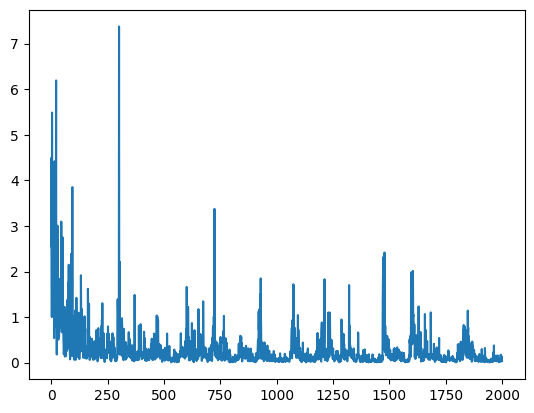

In [23]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot(x=loss_indices, y=losses_float)
plt

In [24]:
import pandas as pd
test_batch = next(iter(test_dl))
with torch.no_grad():
  test_batch.to(device)
  pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
  df = pd.DataFrame()
  df["y_real"] = test_batch.y.tolist()
  df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])

In [25]:
df

,y_real,y_pred
0,-5.230,-2.630482
1,0.610,-0.876468
2,-2.070,-1.673022
3,-1.400,-0.971610
4,-2.000,-2.469910
...,...,...
59,-2.580,-2.800056
60,-4.445,-6.490129
61,-1.830,-2.968065
62,-2.050,-2.136383


<Axes: xlabel='y_real', ylabel='y_pred'>

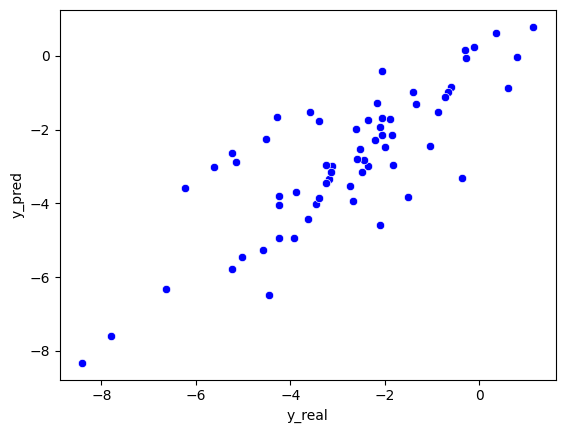

In [31]:
sns.scatterplot(data=df,x="y_real",y="y_pred",color="blue")